# Automatically generating object masks with SAM

## Set-up

In [4]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda:3")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda:3


In [6]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

## Example image

In [7]:
image = Image.open("./images/sds_cats/image.png")
image = np.array(image.convert("RGB"))

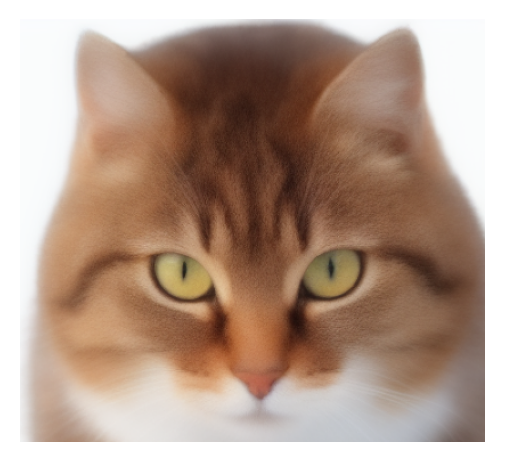

In [17]:
plt.figure(figsize=(3, 5), dpi=200)
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [18]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=True)

In [19]:
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,                  # 增加采样点数以捕获更多细节
    points_per_batch=128,                 # 扩大批处理点数，提高效率
    pred_iou_thresh=0.8,                  # 提高预测 IOU 阈值，生成更精确的 mask
    stability_score_thresh=0.92,          # 提高稳定性分数阈值，仅保留高质量区域
    stability_score_offset=0.7,           # 略微增大偏移量，使 mask 更贴近实际边界
    crop_n_layers=1,                      # 增加裁剪层数，更全面地覆盖猫脸细节
    box_nms_thresh=0.7,                   # 降低 NMS 阈值，允许更多重叠区域（捕获眼睛和耳朵等小特征）
    crop_n_points_downscale_factor=2,     # 不缩放裁剪点数，保留细节
    min_mask_region_area=25,               # 降低最小分割面积阈值，捕获细小的面部特征
    use_m2m=True,                         # 使用 Mask-to-Mask 方法，提升 mask 的边界质量
)

In [32]:
masks = mask_generator.generate(image)

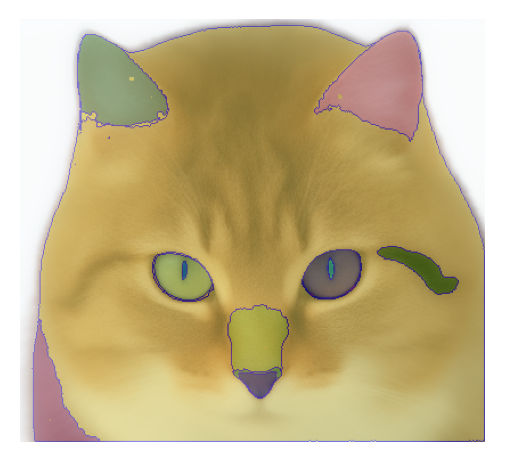

In [33]:
plt.figure(figsize=(3, 3), dpi=200)
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

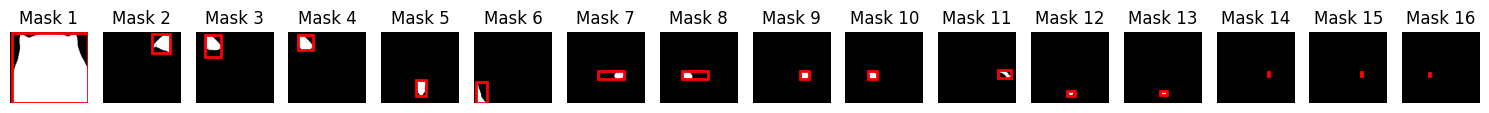

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# 可视化每个 segmentation 的图像
sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)
fig, axs = plt.subplots(1, len(sorted_anns), figsize=(15, 5))
if len(sorted_anns) == 1:
    axs = [axs]  # 确保 axs 是列表，适配单个 mask 的情况

for i, mask in enumerate(sorted_anns):
    axs[i].imshow(mask['segmentation'], cmap='gray')
    
    # 获取并绘制 bbox
    bbox = mask['bbox']
    rect = plt.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3],  # 左上角和宽高
        linewidth=2, edgecolor='red', facecolor='none'
    )
    axs[i].add_patch(rect)
    
    axs[i].set_title(f"Mask {i+1}")
    axs[i].axis('off')
    
plt.tight_layout()
plt.show()


In [84]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

def show_mat(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    
    for ann in sorted_anns:
        # Invert the horse image
        image = ann['segmentation']
        
        # perform skeletonization
        skeleton = skeletonize(image)
        
        # display results
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True)
        
        ax = axes.ravel()
        
        ax[0].imshow(image, cmap=plt.cm.gray)
        ax[0].axis('off')
        ax[0].set_title('original', fontsize=20)
        
        ax[1].imshow(skeleton, cmap=plt.cm.gray)
        ax[1].axis('off')
        ax[1].set_title('skeleton', fontsize=20)
        
        fig.tight_layout()
        plt.show()

In [85]:
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import numpy as np

def show_allmat(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

    # 初始化一个空的骨架合并图像
    combined_skeleton = np.zeros_like(sorted_anns[0]['segmentation'], dtype=bool)

    for ann in sorted_anns:
        # 获取每个 segmentation 图像
        image = ann['segmentation']

        # 执行骨架化
        skeleton = skeletonize(image)

        # 将当前骨架添加到合并图像中
        combined_skeleton |= skeleton

    # 显示合并后的骨架图像
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(combined_skeleton, cmap='gray')
    ax.axis('off')
    ax.set_title('Combined Skeletons', fontsize=20)

    plt.show()
